In [1]:
from PPO_train_test import PPO_train, PPO_train_udr, PPO_train_adr, PPO_test

# Hopper Environment

We want to deploy our agent in the real world that is represented by the Target environment, but we have only access to a simulator (source environment) which has a sistematic error wrt real word.

Since we want to close this sim2real gap we will experiment some techniques to address this problem.

To begin with, we will try a simple UDR. Then our focus will be implementing an ADR technique inspired to the OpenAI original paper where ADR is formally introduced in the RL world.

In the following experiment a PPO, policy-based RL algorithm, will be employed.

In [2]:
TIMESTEPS = 1_000_000
SEED = 123

To begin with, lets train PPO on source and test on source:


--- Training on CustomHopper-source-v0 ---


Output()

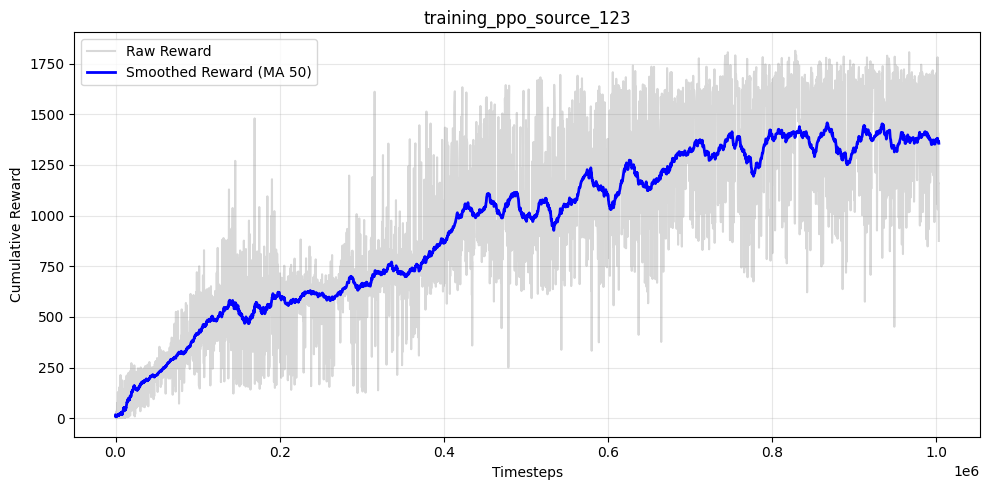

In [3]:
PPO_train(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [4]:
mean, std = PPO_test(
    test_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-source-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test mean cumulative reward 1240.1995105409621 +/- 34.282298161475744


Now, lets test it on target:

In [5]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---
Test mean cumulative reward 681.0708655333519 +/- 12.780407479900385


Now we train PPO on target and test it on target

Output()


--- Training on CustomHopper-target-v0 ---


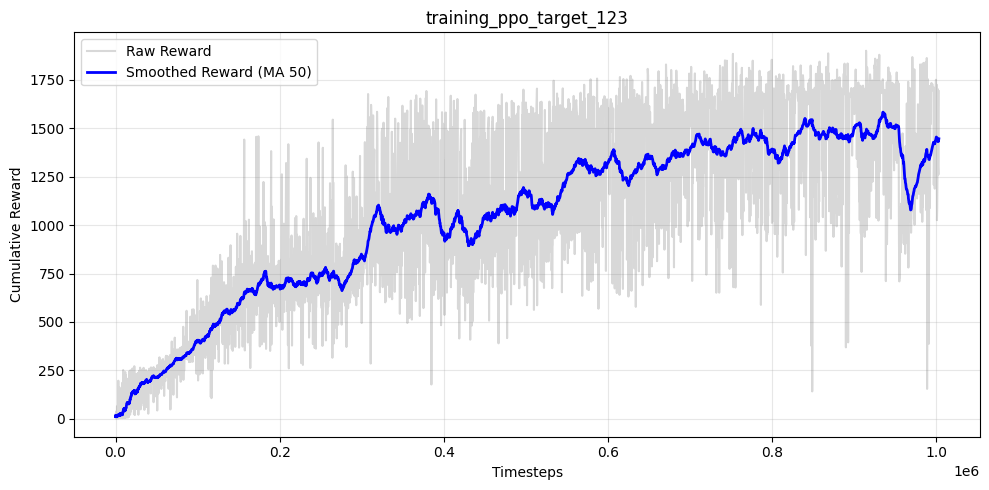

In [6]:
PPO_train(
    train_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [7]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test mean cumulative reward 1694.732754805088 +/- 2.9388833176362703


## UDR

Lets use UDR:

Output()


--- Training on CustomHopper-source-v0 using UDR ---


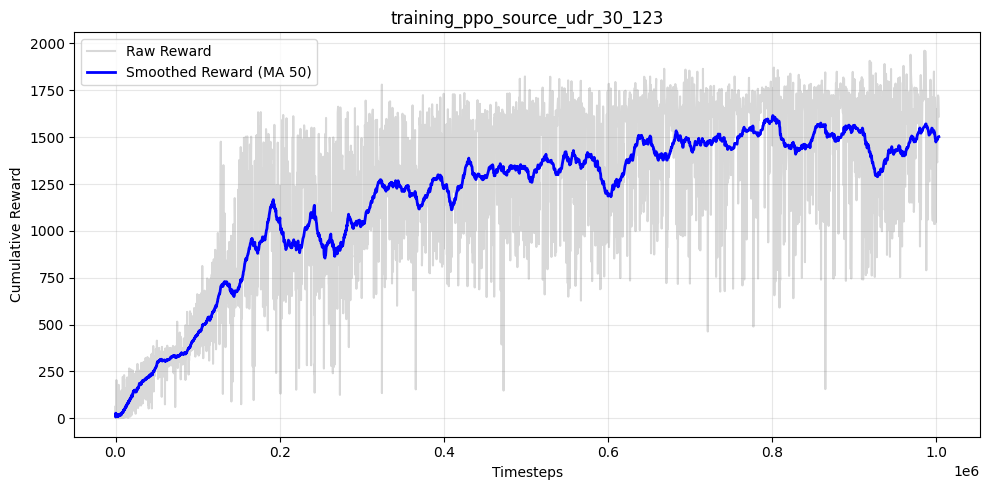

In [8]:
PPO_train_udr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_udr_30_{SEED}',
    lr=3e-4,
    lr_scheduler_type='constant',
    steps=TIMESTEPS,
    udr_range=0.3,
    net_size="medium", # [ small - medium - large ] -> [ 64 - 128 - 256 ],
    seed=SEED
)

In [9]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_udr_30_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test mean cumulative reward 1333.9526766633987 +/- 69.11491854524793


## ADR

Now, lets get serious and use Automatic Domain Randomization (OpenAI style, that is testing the borders before enlarging the distribution range):

Output()


--- Training on CustomHopper-source-v0 using ADR ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

[ADR Boundary Test] Range +/- 5.0% -> Reward: 317.02 +/- 1.7895647416085003

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 526.01 +/- 12.662758407014701

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 616.84 +/- 18.781050415828194

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 686.69 +/- 36.698202104612776

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1451.24 +/- 170.09204113520232

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1445.32 +/- 86.87114685748558

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1447.46 +/- 243.25237403934153

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1119.20 +/- 280.8989085617987

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1090.75 +/- 150.73096919635495

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1275.42 +/- 252.51704738306765

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1466.07 +/- 244.23069718750125

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1187.60 +/- 343.829408451446

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1273.74 +/- 341.16398003192603

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1514.39 +/- 339.33952959157574

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1359.40 +/- 367.9766389231225

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1617.21 +/- 171.0689408658827

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1436.98 +/- 404.2236819569557

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1454.61 +/- 290.60278882308995

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1386.27 +/- 245.10147643048697

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1514.26 +/- 216.2882812590342

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1394.39 +/- 336.3758749118156

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1606.00 +/- 164.47164781093767

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1652.70 +/- 106.15598075800473

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1462.67 +/- 325.62048542183476

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1747.43 +/- 218.01997599765448

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1645.73 +/- 177.21187935000353

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1581.05 +/- 201.74651205044978

[ADR Boundary Test] Range +/- 30.0% -> Reward: 891.45 +/- 382.40953066665594

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1340.85 +/- 448.04955049703665

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1581.28 +/- 291.8666393399331

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1717.79 +/- 189.21435227881486

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1505.01 +/- 280.7702817221422

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1295.87 +/- 392.85892217483126

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1635.45 +/- 279.83136032053994

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1483.00 +/- 399.04051225757223

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1396.89 +/- 340.49634568079597

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1399.31 +/- 338.61805574570786

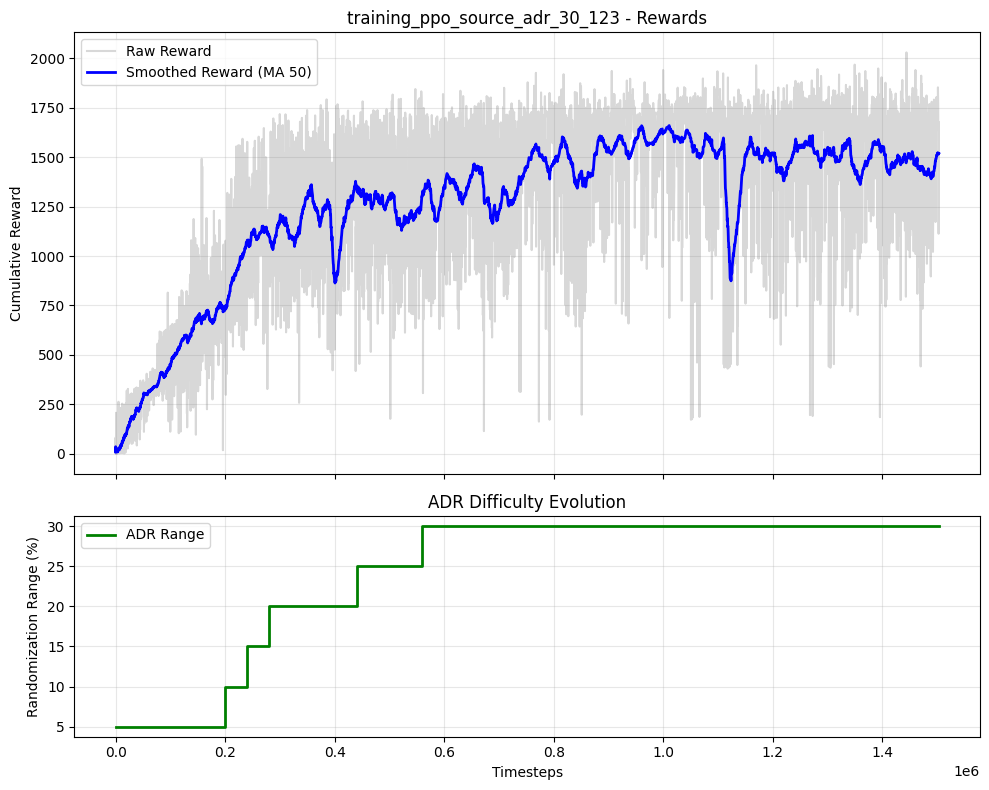

In [10]:
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_adr_30_{SEED}',
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=1_500_000,
    starting_adr_range=0.05,
    objective_adr_range=0.3,
    increase_rate=0.05,
    reward_to_check=1400, # forse troppo alto ?
    check_frequency=40_000, # forse troppo alto ?
    net_size="medium",
    seed=SEED
)

Output()


--- Training on CustomHopper-source-v0 using ADR ---


[ADR Boundary Test] Range +/- 5.0% -> Reward: 57.48 +/- 1.1137552146858845

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 209.86 +/- 1.9474019482219116

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 311.33 +/- 2.754309549575404

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 376.39 +/- 3.569800378294337

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 415.58 +/- 3.65541489057973

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 440.27 +/- 4.019630925533521

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 496.74 +/- 11.860365858485626

[ADR Boundary Decreased] New Range +/- 5.0%

[ADR Boundary Test] Range +/- 5.0% -> Reward: 782.01 +/- 58.05622283453165

[ADR Boundary Test] Range +/- 5.0% -> Reward: 843.55 +/- 58.38194353836669

[ADR Boundary Test] Range +/- 5.0% -> Reward: 767.66 +/- 32.05871899761919

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1031.79 +/- 26.78325628077494

[ADR Boundary Test] Range +/- 5.0% -> Reward: 1383.84 +/- 89.29297169248068

[ADR Boundary Increased] New Range +/- 10.0%

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1124.84 +/- 136.61055453857858

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1155.41 +/- 179.70850658577697

[ADR Boundary Test] Range +/- 10.0% -> Reward: 1346.93 +/- 191.75227615897407

[ADR Boundary Increased] New Range +/- 15.0%

[ADR Boundary Test] Range +/- 15.0% -> Reward: 1297.90 +/- 309.87342015159464

[ADR Boundary Increased] New Range +/- 20.0%

[ADR Boundary Test] Range +/- 20.0% -> Reward: 1316.29 +/- 226.22836469902458

[ADR Boundary Increased] New Range +/- 25.0%

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1154.94 +/- 151.2558520261996

[ADR Boundary Test] Range +/- 25.0% -> Reward: 1370.65 +/- 256.859796869948

[ADR Boundary Increased] New Range +/- 30.0%

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1335.03 +/- 257.30032247261556

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1255.27 +/- 254.6913400699321

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1312.53 +/- 88.3214106712257

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1255.78 +/- 153.15521347774876

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1257.54 +/- 322.4484910103133

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1367.86 +/- 279.6771882462492

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1164.35 +/- 256.89143853007687

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1153.90 +/- 283.03005202280104

[ADR Boundary Test] Range +/- 30.0% -> Reward: 936.89 +/- 302.34097308820463

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1091.70 +/- 423.1030265535744

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1085.01 +/- 298.90736903651333

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1253.89 +/- 271.18093316893606

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1275.82 +/- 180.1659676819334

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1113.08 +/- 305.71155481651186

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1278.27 +/- 299.2675110579261

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1349.43 +/- 217.14830802258695

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1130.52 +/- 279.9032872215764

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1257.41 +/- 343.3760402597538

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1110.87 +/- 316.5559699306938

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1234.34 +/- 364.85302466841983

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1194.29 +/- 422.8019175556152

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1099.54 +/- 363.7845495631618

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1187.86 +/- 451.02265375486223

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1160.91 +/- 401.1560807302743

[ADR Boundary Test] Range +/- 30.0% -> Reward: 920.30 +/- 376.32877468361124

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1237.06 +/- 372.255833563871

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1178.24 +/- 350.76991621326505

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1130.56 +/- 317.92054812630386

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1299.12 +/- 301.59454742021137

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1175.02 +/- 298.3609776579426

[ADR Boundary Test] Range +/- 30.0% -> Reward: 1261.88 +/- 401.9619856170207

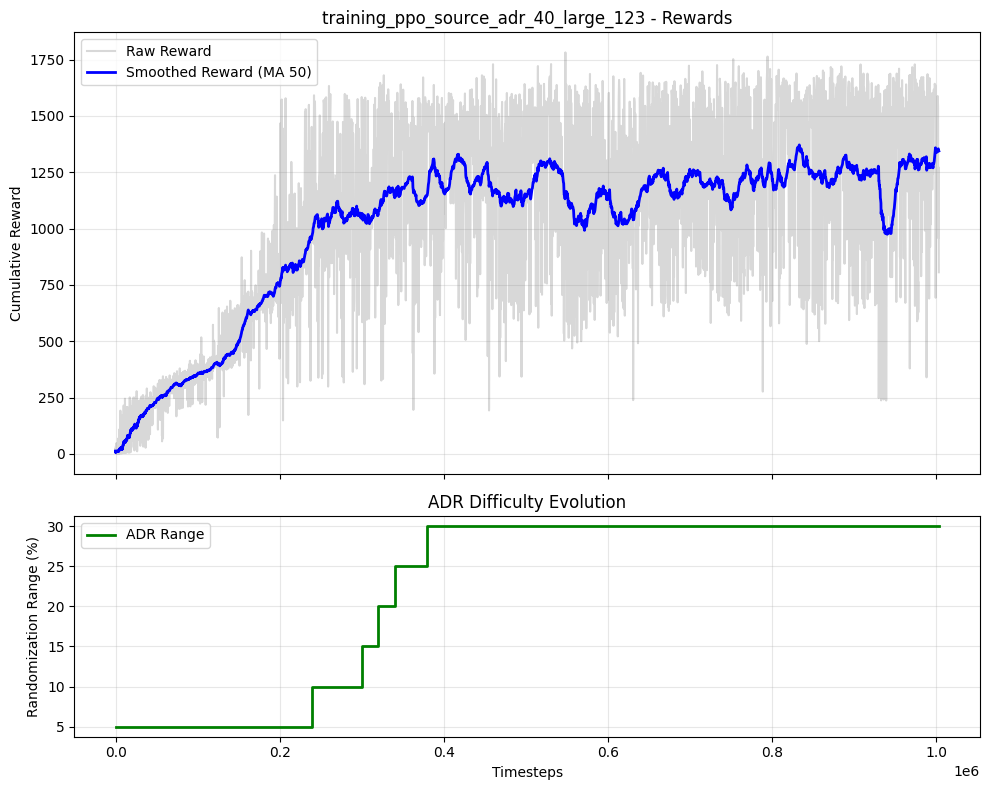

In [ ]:
# consigliata
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}',
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=TIMESTEPS, # 1.5M aiuterebbe
    starting_adr_range=0.05,
    objective_adr_range=0.3,
    increase_rate=0.05,
    reward_to_check=1200,   # <--- MODIFICA CRUCIALE: Lascialo salire prima
    check_frequency=20_000, # <--- Più reattivo
    net_size="large",       # <--- MODIFICA CRUCIALE: Più neuroni per gestire il caos
    seed=SEED
)

In [13]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test mean cumulative reward 629.9044739913941 +/- 8.760615065689294


## Visualization

In [ ]:
from utils.visualize_agent import visualize

model = f"ppo_source_adr_40_{SEED}"

visualize(
    model_path=f"models/{model}",
    env_id="CustomHopper-target-v0"
)